#### Task 1.2: Data Preparation

Improve the quality of your data and prepare it by extracting new features interesting for describing the incidents. Some examples of indicators to be computed are:

- How many males are involved in incidents relative to the total number of males for the same city and in the same period?
- How many injured and killed people have been involved relative to the total injured and killed people in the same congressional district in a given period of time?
- Ratio of the number of killed people in the incidents relative to the number of participants in the incident
- Ratio of unharmed people in the incidents relative to the average of unharmed people in the same period

Note that these examples are not mandatory, and teams can define their own indicators. Each indicator must be correlated with a description and, when necessary, its mathematical formulation. The extracted variables will be useful for the clustering analysis in the second project's task. Once the set of indicators is computed, the team should explore the new features for a statistical analysis, including distributions, outliers, visualizations, and correlations.

For task 1.1 see the corresponding Notebook in [Task 1.1 - Data Understanding](Task1_Data_Understanding.ipynb).

For this task we followed the following check structure: [#WIP]()
1. Data aggregation
2. Reduction of dimensionality
3. Data cleaning
4. Discretization
5. Data transformation
6. Principal Component Analysis via Covariance Matrix
8. Data Similarity via Entropy and proximity coefficients


In [1]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)

# Load dataset from data understanding
#df_incident_du = pd.read_csv('../ds/cleaned/incidents_cleaned.csv')
df = pd.read_hdf('../ds/cleaned/incidents_cleaned.h5', key = 'df')
df_incident_du = df.copy()   
df_poverty_du = pd.read_csv('../ds/cleaned/poverty_cleaned.csv')
df_years_state_du = pd.read_csv('../ds/cleaned/year_state_votes_cleaned.csv')


In [2]:
# Check if dataset loaded correctly
#df_incident_du.head()
#df_poverty_du.head()
df_years_state_du.head()

#df_incident_du.info()

,year,state,congressional_district,party,candidatevotes,totalvotes
0,2014,Alabama,1,REPUBLICAN,103758,152234
1,2014,Alabama,2,REPUBLICAN,113103,167952
2,2014,Alabama,3,REPUBLICAN,103558,156620
3,2014,Alabama,4,REPUBLICAN,132831,134752
4,2014,Alabama,5,REPUBLICAN,115338,154974


### Fix little problem with reimporting datasets

CSV files do not store informations about categories and datatypes like the one we saved.

# Joining the datasets

We have three dataset: the one with the incidents, one with poverty by state (just two columns) and one with year, state and how much votes each party got. We want to join the three datasets in order to have a single dataset with all the information we need. 

In [3]:
# We need to do merge function from pandas

df_merged_incident_poverty = pd.merge(df_incident_du ,df_poverty_du, on=['year', 'state'], how='left')

# This produces nans on 70k party columns...
#df_merged_incident_votes = pd.merge(df_merged_incident_poverty ,df_years_state_du, on=['year', 'state', 'congressional_district'], how='left')

df_merged_incident_poverty.head()

#df_merged_incident_votes.head()

df_merged = df_merged_incident_poverty.copy()

# drop from memory using
del [[df_merged_incident_poverty]]

# now merge the two merged
#df_merged = pd.merge(df_merged_incident_votes ,df_poverty_du, on=['year', 'state'], how='left')

df_merged.head()


,date,state,city_or_county,latitude,longitude,congressional_district,participant_age1,participant_age_group1,participant_gender1,min_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,year,povertyPercentage
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8
1,2014-01-01,California,Bakersfield,35.3229,-119.0380,23,28,Adult 18+,Male,28,28,0,0,0,0,2,0,0,2,Shot - Wounded/Injured,2014,14.5
2,2014-01-01,Iowa,Iowa City,41.6611,-91.5302,2,35,Adult 18+,Female,35,35,0,0,2,0,1,0,1,2,other,2014,10.1
3,2014-01-01,New York,Brooklyn,40.6505,-73.9573,9,28,Adult 18+,Male,28,30,0,0,1,0,3,0,0,3,Shot - Wounded/Injured,2014,13.4
4,2014-01-01,Colorado,Grand Junction,39.0496,-108.5250,3,47,Adult 18+,Male,47,47,0,0,0,1,0,0,0,1,"Shot - Dead (murder, accidental, suicide)",2014,10.2


# Implementation of default indexes
### 1. *How many males are involved in incidents w.r.t. the total number of males for the same city and in the same period?*

In [4]:
# Filter the DataFrame to include only rows where gender is specified as male
male_incidents = df_merged.copy()
male_incidents['n_males'] = male_incidents['n_participants'] - male_incidents['n_females']

male_incidents = male_incidents[male_incidents['n_males'] > 0]


# Group by city and year, and count the number of males involved in incidents
male_incidents_count = male_incidents.groupby(['state', 'city_or_county', 'year'])['n_participants'].sum().reset_index()

# Total males and females for each city and year
male_plus_female_count = df_merged.groupby(['state', 'city_or_county', 'year'])['n_participants'].sum().reset_index()

# Merge the total number of males involved in incidents per city and year back to the original DataFrame
merged_with_total_males = pd.merge(male_plus_female_count, male_incidents_count, on=['state', 'city_or_county', 'year'], suffixes=('_total', '_total_male'))


# Calculate the indicator: number of males involved in incidents w.r.t. the total number of males for the same city and in the same period
merged_with_total_males['males_indicator'] = merged_with_total_males['n_participants_total'] / merged_with_total_males['n_participants_total_male']

# Drop unnecessary columns
merged_with_total_males = merged_with_total_males.drop(['n_participants_total', 'n_participants_total_male'], axis=1)

#Merge the new indicator to the original DataFrame
df_merged = pd.merge(df_merged, merged_with_total_males, on=['state', 'city_or_county', 'year'])



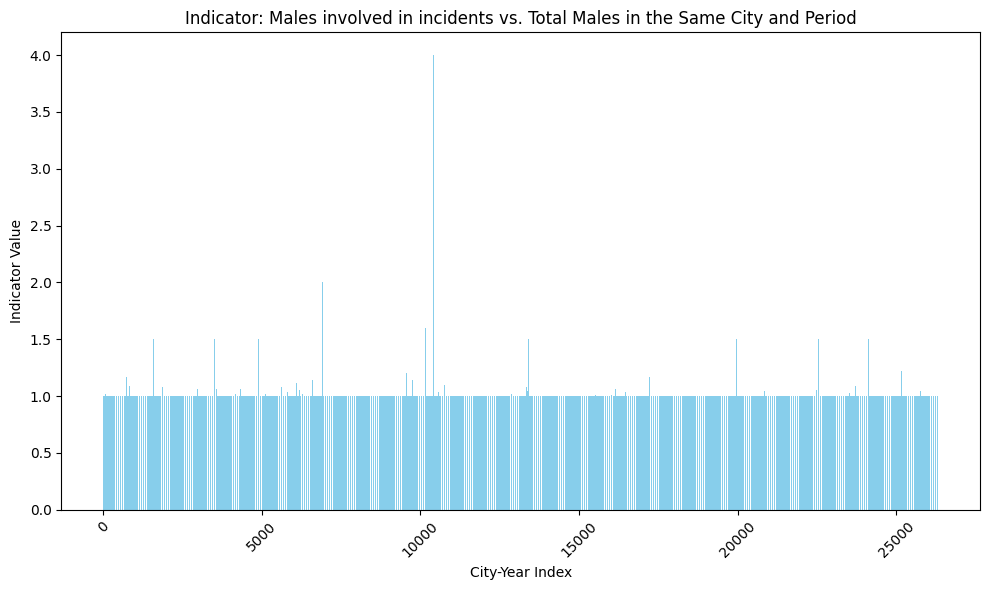

In [5]:
# Filter the indicator data for better visualization (optional step)
indicator_data = merged_with_total_males[['state', 'city_or_county', 'year', 'males_indicator']]

# Calculate the mean indicator value per city and year
mean_indicator_per_city_year = indicator_data.groupby(['state', 'city_or_county', 'year'])['males_indicator'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(mean_indicator_per_city_year.index, mean_indicator_per_city_year['males_indicator'], color='skyblue')
plt.xlabel('City-Year Index')
plt.ylabel('Indicator Value')
plt.title('Indicator: Males involved in incidents vs. Total Males in the Same City and Period')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In most of the incidents the ratio is equal to 1 but some incidents report an increased partecipation of mlaes respect to the total males in the smame period for the same city. Let's analyze in which state and in which city or county those incidents happens:

In [6]:
# Filter records where the indicator is greater than 1
filtered_data = merged_with_total_males[merged_with_total_males['males_indicator'] > 1]

# Count the occurrences of each state and city/county
state_counts = filtered_data['state'].value_counts()
city_counts = filtered_data['city_or_county'].value_counts()

# Get the state and city/county with the highest occurrence
state_with_most_incidents = state_counts.idxmax()
city_with_most_incidents = city_counts.idxmax()

# Output the state and city/county with the most incidents where the indicator is > 1
print("State with most incidents where indicator > 1:", state_with_most_incidents)
print("City/County with most incidents where indicator > 1:", city_with_most_incidents)

del [[male_incidents]]
del [[merged_with_total_males]]

State with most incidents where indicator > 1: Florida
City/County with most incidents where indicator > 1: Springfield


It's noticeable to highlight that the city of Springfield is not in the State of Florida, so can have a relevance for the record that refer the Springfield city.


## 2. Ratio of the number of the killed people in the incident w.r.t. the number of participants in the incident

How we can see the majority of the incidents have a ratio of 0 and there are not a lot of different ration, they are just 7,
we could try to discretize this feature in order to have a better visualization. By making this a categorical feature we can see that the majority of the incidents have a ratio of 0 and there are not a lot of different ration, they are just 7.

Let's visualize it with a barplot.

In [7]:

# divide for each incident n_killed by n_participants
df_merged['n_killed_per_participant'] = df_merged['n_killed'] / df_merged['n_participants']


In [8]:

# groupby different value of n_killed_per_participant
print(df_merged.groupby('n_killed_per_participant').size())

n_killed_per_participant
0.000000    91989
0.250000     1830
0.333333     4666
0.500000    15824
0.666667      860
0.750000      136
1.000000    18635
dtype: int64


### Discretization of the ratio

Let's discretize these values into 3 main categories since we have a lot of incidents with ratio being 0 and this is first category: let's call it: **"No deaths"**, these can be those were someone just shot in the air or something like this, we could do more by using the **incidents_charactetistics1** and see what type of those is the majority.

Then we have some of incidents with ratio from 0.25, 0.33, 0.5 (that is the majority), 0.66 and 0.75 and this is second category, so incidents where someone died but not all the people involved in the incident: let's call it: **"Some deaths"**.

Then we have another category with lots of incidents with ratio being 1 and this is third category: **"All deaths"**.

<Axes: ylabel='n_killed_per_participant'>

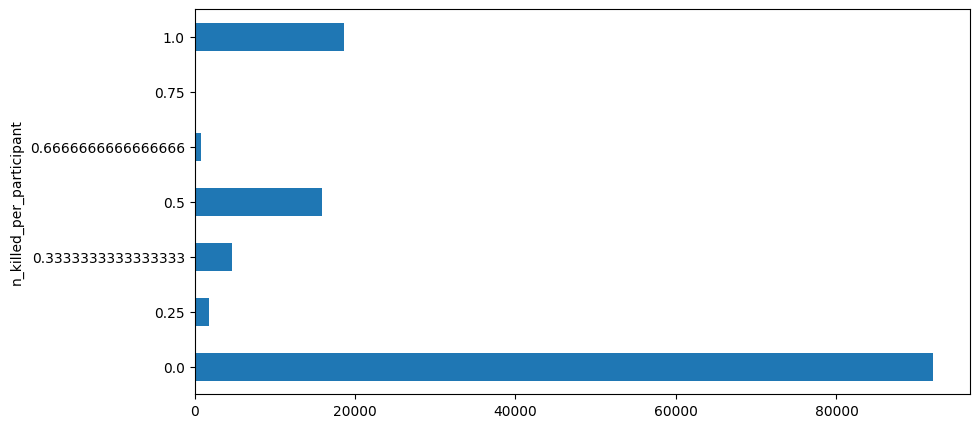

In [9]:
# Barplot of n_killed_per_participant and number of incidents using our groupby rotated along the y axis
df_merged.groupby('n_killed_per_participant').size().plot(kind='barh', figsize=(10, 5), rot=0)

#df_merged.groupby('n_killed_per_participant').size().plot(kind='bar', figsize=(10, 5), rot=0)

In [10]:
# Discretize by gathering the n_killed_per_participants into 3 categories as we discussed
# If ration is [0,0.1), then label is 'No deaths', if ratio is [0.1, 0.75), then label is 'Some deaths', if ratio is [0.75, 1], then label is 'All deaths'

ratios = {'No deaths': [0, 0.1], 'Some deaths': [0.1, 0.75], 'All deaths': [0.75, 1]}

# map to n_killed_per_participant

df_merged['n_killed_per_participant'] = df_merged['n_killed_per_participant'].map(
    lambda x: 'No deaths' if x >= ratios['No deaths'][0] and x < ratios['No deaths'][1] else 
    ('Some deaths' if x >= ratios['Some deaths'][0] and x < ratios['Some deaths'][1] else 'All deaths'))


<Axes: ylabel='n_killed_per_participant'>

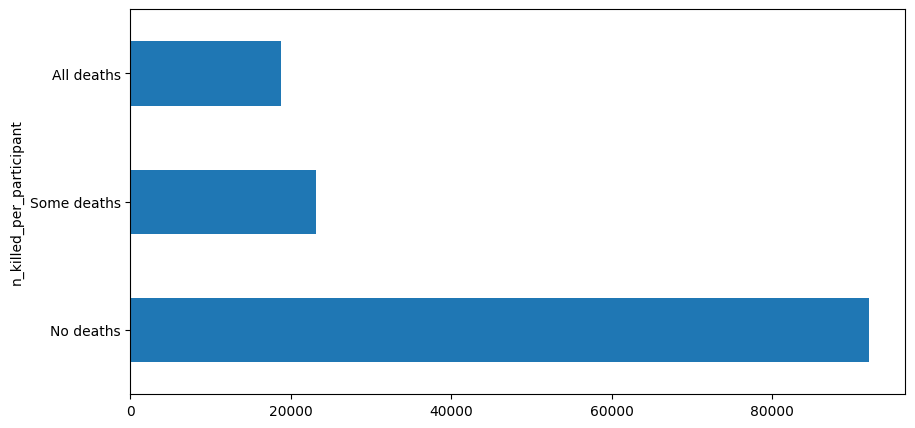

In [11]:
#df_merged.head()
# order the categories from 'No deaths' to 'All deaths'
df_merged['n_killed_per_participant'] = pd.Categorical(df_merged['n_killed_per_participant'], 
                                                       categories=['No deaths', 'Some deaths', 'All deaths'], 
                                                       ordered=True)

# Barplot after discretization
df_merged.groupby('n_killed_per_participant').size().plot(kind='barh', figsize=(10, 5), rot=0)

## 3. How many injured and killed people have been involved w.r.t the total injured and killed people in the same STATE during 2016 - 2018

In [12]:
df_merged_incident_poverty = df_merged.copy()

desired_years = [2016, 2017, 2018]

df_filtered = df_merged_incident_poverty[df_merged_incident_poverty['year'].isin(desired_years)]
# Group by congressional district
grouped_district = df_filtered.groupby('state')

#number of injured for each district
total_injured_district = df_merged_incident_poverty.groupby('state')['n_injured'].sum().reset_index()

#number of killed for each district
total_killed_district = df_merged_incident_poverty.groupby('state')['n_killed'].sum().reset_index()

# Calculate the total number of killed and injured people for each district
total_killed_injured = grouped_district[['n_killed', 'n_injured']].sum().reset_index()

# Calculate the total number of injured people relative to the total of injured and killed for each district
total_killed_injured['percentage_injured'] = (total_killed_injured['n_injured'] / (total_killed_injured['n_killed'] + total_killed_injured['n_injured'])) * 100
# Calculate the total number of injured people relative to the total of injured and killed for each district
total_killed_injured['percentage_killed'] = (total_killed_injured['n_killed'] / (total_killed_injured['n_killed'] + total_killed_injured['n_injured'])) * 100

# Drop the n_killed and n_injured columns as are useless and duplicated
total_killed_injured.drop(['n_killed', 'n_injured'], axis=1, inplace=True)

# Merge the total_killed_injured DataFrame with the total_killed_district DataFrame
df_merged = pd.merge(df_merged, total_killed_injured, on=['state'])




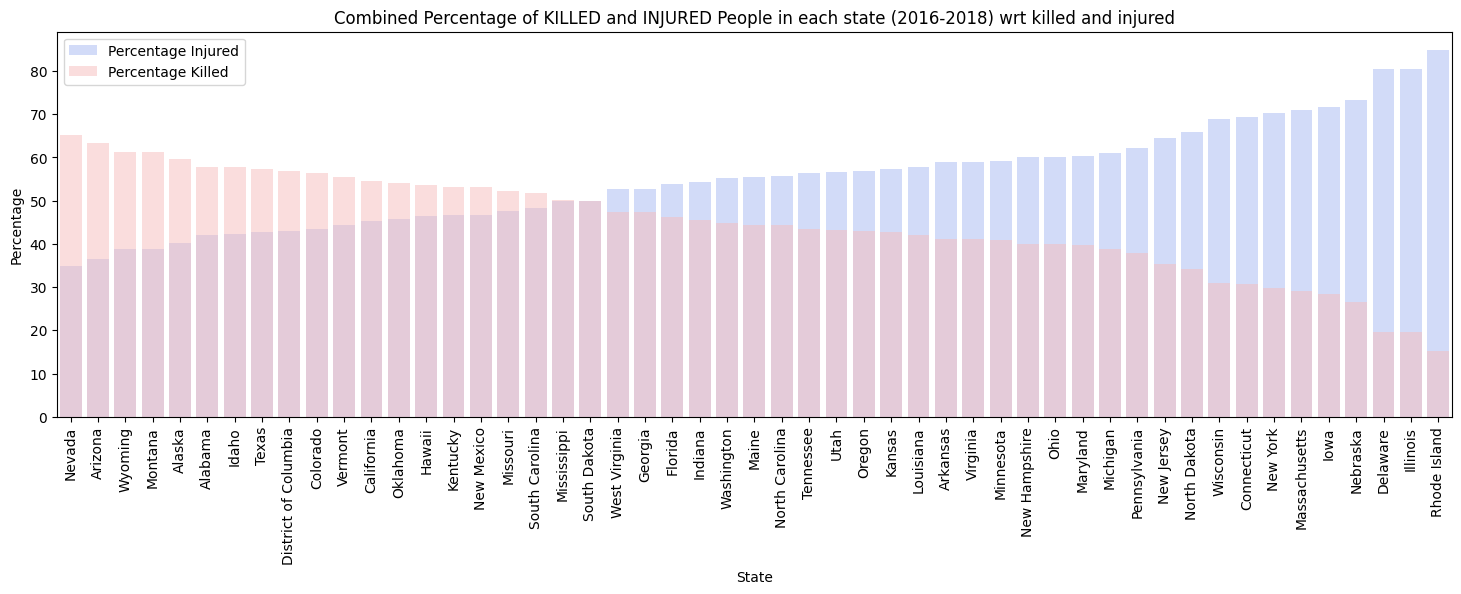

In [13]:
# Plot for combined percentage of killed and injured people
plt.figure(figsize=(18, 5))

# Order by percentage of killed people
total_killed_injured = total_killed_injured.sort_values(by='percentage_killed', ascending=False)

# Plotting killed percentage
# Plotting injured percentage
sns.barplot(x='state', y='percentage_injured', data=total_killed_injured, color='#99b3ff', label='Percentage Injured', alpha = 0.5)
sns.barplot(x='state', y='percentage_killed', data=total_killed_injured, color='#ffb3b3', label='Percentage Killed' , alpha = 0.5)
plt.title('Combined Percentage of KILLED and INJURED People in each state (2016-2018) wrt killed and injured')
plt.xlabel('State')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.legend()

plt.show()

del [[total_killed_injured]]


## 4. *Ratio of unharmed people in the incident w.r.t. the average of unharmed people involved in incidents for the same period*

Due to dataframe dimension we computed the fourth index in another Notebook to avoid kernel panic. 

We save the result and retrieve the aggregated dataset from the file `index_4_cleaned.csv` to join the new indicator with the already computed in DF `df_merged`.

In [14]:
df_merged_unharmed = pd.read_csv('../ds/cleaned/index_4_cleaned.csv')

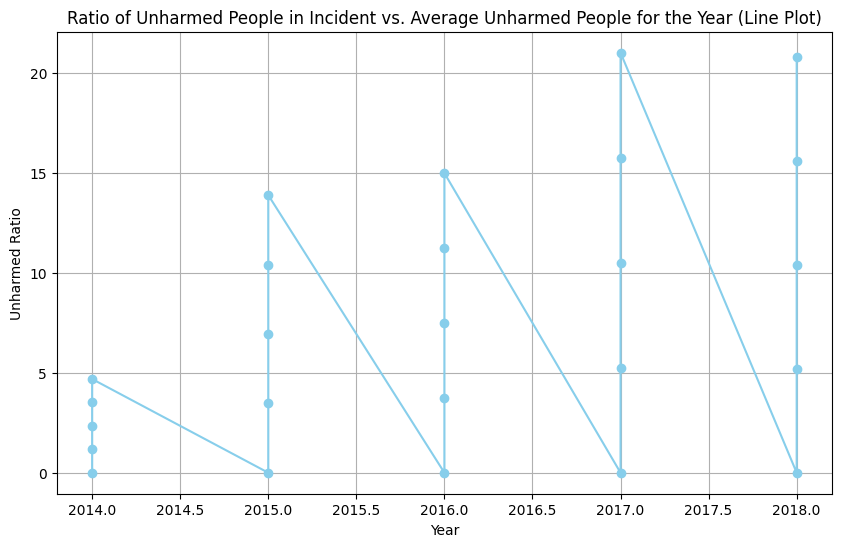

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(df_merged_unharmed['year'], df_merged_unharmed['unharmed_ratio'], marker='o', linestyle='-', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Unharmed Ratio')
plt.title('Ratio of Unharmed People in Incident vs. Average Unharmed People for the Year (Line Plot)')
plt.grid(True)
plt.show()

Another visualization is by using the bar chart:

In [17]:
"""
plt.figure(figsize=(10, 6))
plt.bar(df_merged_unharmed['year'], df_merged_unharmed['unharmed_ratio'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Unharmed Ratio')
plt.title('Ratio of Unharmed People in Incident vs. Average Unharmed People for the Year (Bar Plot)')
plt.show()
"""

df_merged = pd.merge(df_merged, df_merged_unharmed, on=['year'])


In [18]:
df_merged.head()


,date,state,city_or_county,latitude,longitude,congressional_district,participant_age1,participant_age_group1,participant_gender1,min_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,year,povertyPercentage,males_indicator,n_killed_per_participant,percentage_injured,percentage_killed,unharmed_ratio
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,0.000000
1,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,1.172595
2,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,2.345189
3,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,3.517784
4,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,4.690378


## Number of incident density per state

Let visualize with the map and the density of incidents per state.

In [19]:
import plotly.graph_objs as go

# density of incident per state

# Densities are n_participants in that state divided by the total number of participants in the dataset
densities = df_merged.groupby('state')['n_participants'].sum()/ df_merged['n_participants'].sum()

# normalize densities using min-max normalization
densities = (densities - densities.min()) / (densities.max() - densities.min())

# order by density
densities = densities.sort_values()

# plot a bar plot

data = [go.Bar(
            x=densities.index, # assign x as the dataframe column 'x'
            y=densities.values
    )]  

py.iplot(data, filename='basic-bar')

# add this as index to the dataframe
df_merged['density_incident_state'] = df_merged['state'].map(densities)


In [20]:
df_merged.head()

,date,state,city_or_county,latitude,longitude,congressional_district,participant_age1,participant_age_group1,participant_gender1,min_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,year,povertyPercentage,males_indicator,n_killed_per_participant,percentage_injured,percentage_killed,unharmed_ratio,density_incident_state
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,0.000000,0.135621
1,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,1.172595,0.135621
2,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,2.345189,0.135621
3,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,3.517784,0.135621
4,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,4.690378,0.135621


## n.Ratio males to females per incident

This can arise some information with the other categorical variables.


In [21]:
# ratio males to females participants in each incident
# in order to get this ratio

df_merged['males_to_females_ratio'] = (df_merged['n_participants']-df_merged['n_females']) / df_merged['n_females'].replace(0, 1)


In [22]:
df_merged.head()

,date,state,city_or_county,latitude,longitude,congressional_district,participant_age1,participant_age_group1,participant_gender1,min_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,year,povertyPercentage,males_indicator,n_killed_per_participant,percentage_injured,percentage_killed,unharmed_ratio,density_incident_state,males_to_females_ratio
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,0.000000,0.135621,2.0
1,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,1.172595,0.135621,2.0
2,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,2.345189,0.135621,2.0
3,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,3.517784,0.135621,2.0
4,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,1.0,No deaths,58.850575,41.149425,4.690378,0.135621,2.0


date                         0
state                        0
city_or_county               0
latitude                     0
longitude                    0
congressional_district       0
participant_age1             0
participant_age_group1       0
participant_gender1          0
min_age_participants         0
max_age_participants         0
n_participants_child         0
n_participants_teen          0
n_females                    0
n_killed                     0
n_injured                    0
n_arrested                   0
n_unharmed                   0
n_participants               0
incident_characteristics1    0
year                         0
povertyPercentage            0
males_indicator              0
n_killed_per_participant     0
percentage_injured           0
percentage_killed            0
unharmed_ratio               0
density_incident_state       0
males_to_females_ratio       0
dtype: int64

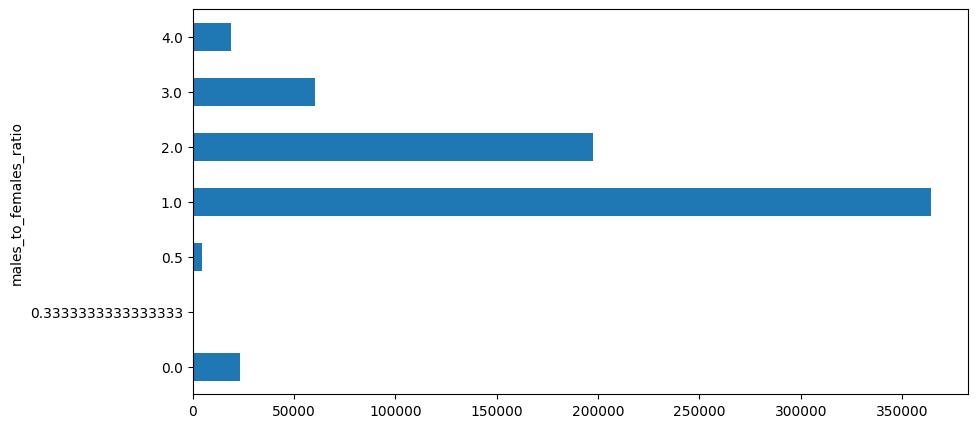

In [23]:
# Group by ratio male females and do barplot

# now the other way around
df_merged.groupby('males_to_females_ratio')['participant_age_group1'].count().plot(kind='barh', figsize=(10, 5), rot=0) 

# We see very few incidents from 0 to 0.5, then a lot at 1, then half than the 1 for the ratio of 2, and so on until 4
# We can say that in half of incidents the ratio is 1 and in the rest more man dies...

df_merged_pca = df_merged.copy()

# Check for nans
df_merged_pca.isnull().sum()

In [24]:

plot_correlation(df_merged.select_dtypes(include=[np.number]).columns, df_merged)

NameError: name 'plot_correlation' is not defined

## PCA Analysis

Let's perform a PCA analysis on the new data we have created.


### Pairplot

In [ ]:
df_merged.describe()

## Before PCA we need to preprocess

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_merged_pca.select_dtypes(include=[np.number]))

pca = PCA(n_components=5)
X_pca = pca.fit(X_scaled)

# getting eigenvalues and eigenvectors
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

explained_variance_ratio = pca.explained_variance_ratio_

# Screeplot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o')
#add grid
plt.grid()
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()


# print categorical columns
print(df_merged_pca.select_dtypes(include=['category']).columns)


""" 
# project the two more separated components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_merged_pca['n_killed_per_participant'].cat.codes, cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of incidents on the first two principal components')
plt.show()

 """

In [ ]:
# take first 3 components
pca = PCA(n_components = 3)

principal_components = pca.fit_transform(X_scaled)

# transform original dataframe with the new components
df_merged_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2', 'PC3'])

MAX_SAMPLES = len(df_merged_pca)
# sample 4000 incidents
df_merged_pca = df_merged_pca.sample(n=40000, random_state=42)

""" plt.scatter(df_merged_pca['PC1'], df_merged_pca['PC2'], cmap=plt.cm.Set1, edgecolor='k', s=4)
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
plt.show() """

In [ ]:
df_merged_pca.head()

# Plots comulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio)+1), np.cumsum(explained_variance_ratio), marker='o')
plt.grid()
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [ ]:
# Scatter plot of the first two components
plt.figure(figsize=(10, 8))
plt.scatter(df_merged_pca['PC1'], df_merged_pca['PC2'], s=0.1)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of incidents on the first two principal components')
plt.show()

In [ ]:
#Scatter plot of second and third components
plt.figure(figsize=(10, 8))
plt.scatter(df_merged_pca['PC2'], df_merged_pca['PC3'], s=0.1)
plt.xlabel('Second principal component')
plt.ylabel('Third principal component')
plt.title('Projection of incidents on the second and third principal components')

In [ ]:
# Overlap three components
from mpl_toolkits.mplot3d import Axes3D
# color each component with different color


fig = plt.figure(figsize=(10, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 1, .95, 1], elev=15, azim=35)
plt.cla()
ax.scatter(df_merged_pca['PC1'], df_merged_pca['PC2'], df_merged_pca['PC3'], c=df_merged_pca['PC1'], cmap='viridis', s=0.1)
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.set_zlabel('Third principal component')
plt.show()


# Print what are the most important features for each component

# Clustering Analysis


## Geographical Clustering

1. We want to cluster the states based on the number of incidents per state. We will use the K-Means algorithm.
2. We can explore if some regions or states have similar incidents characteristics.

In [ ]:
# Before Kmeans let's do some feature engineering

# We want to cluster state based on the number of incidents per state: we can use the density we computed before
# Now let's see the elbow method to see how many clusters we should use


In [ ]:
# Import libraries for K-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm



# Select the features we want to use for clustering: States because we want incidents per state
# Let's encode the states with coordinate of our tuples of latitude and longitude

""" The way kmeans algorithm works is as follows:

    Specify number of clusters K.
    Initialize centroids by first shuffling the dataset and then randomly selecting K data points for the centroids without replacement.
    Keep iterating until there is no change to the centroids. i.e assignment of data points to clusters isn’t changing.

    Compute the sum of the squared distance between data points and all centroids.
    Assign each data point to the closest cluster (centroid).
    Compute the centroids for the clusters by taking the average of the all data points that belong to each cluster.

DENSITY_INCIDENT_STATE = False

if DENSITY_INCIDENT_STATE:
    ## KMenas clustering for incident x state using the density of incidents per state
    X = df_merged[['density_incident_state']].values
else:
    # Assuming df is your DataFrame with latitude and longitude columns
    X = df[['latitude', 'longitude']]

# Standardize the features (important for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# We want to cluster the states based on the number of incidents per state
# We want to find the optimal number of clusters using the elbow method
# We want to use the silhouette score to evaluate the quality of the clusters

# We will try different number of clusters from 2 to 10
n_clusters = np.arange(2, 11)

silhouette_scores = []
inertia_scores = []
kmeans_models = []
elbow_scores = []

# For each number of clusters
for n in tqdm(n_clusters):
    # Initialize the KMeans model with n_clusters=n
    # Use KMenans++ initialization for faster convergence
    kmeans = KMeans(n_clusters=n, random_state=42,
                    n_init=10, max_iter=100, algorithm='lloyd', init='k-means++')

    # Fit the model
    kmeans.fit(X)
    print("Current model:", kmeans)
    
    # Get the inertia score
    inertia_scores.append(kmeans.inertia_)
    print("Current inertia score:", kmeans.inertia_)
    
    # Get the silhouette score
    #silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    #print("Current silhouette score:", silhouette_score(X, kmeans.labels_))
    
    # Store the model
    kmeans_models.append(kmeans)
    """

# Eblow method to get ideal number of clusters

We can see that the ideal number of clusters is 5.

In [ ]:
# Plot the inertia score for each number of clusters o
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, inertia_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia score')
plt.title('Inertia score for different number of clusters')
plt.show()




In [ ]:

N_CLUSTER_PREDICT = 5

df_clusters = df_merged.copy()

# Add the cluster labels to the dataframe
df_clusters['cluster'] = kmeans_models[N_CLUSTER_PREDICT].labels_

# centroids
centroids = kmeans_models[N_CLUSTER_PREDICT].cluster_centers_


# For logitude and latitude clustering visualization

In [ ]:
# Visualize the clusters (scatter plot of latitude and longitude with different colors for each cluster)
plt.figure(figsize=(10, 6))

plt.scatter(df_clusters['longitude'], df_clusters['latitude'], c=df_clusters['cluster'], cmap='viridis', alpha=0.5)
plt.title('KMeans Clustering of Incidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



## For density incident state


In [ ]:

# Not execute this cell if DENSITY_INCIDENT_STATE is False to do it in ipynb use: 


# Visualizing cluster
plt.figure(figsize=(10, 6))

# Plot the clusters
plt.scatter(df_clusters['density_incident_state'], df_clusters['n_participants'], c=df_clusters['cluster'], cmap='rainbow')
# add centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, alpha=0.5)
plt.xlabel('density_incident_state')
plt.ylabel('n_participants')
plt.title('Clusters of states based on density of incidents per state and number of participants')
plt.show()

